In [3]:
# Import packages
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import umap
from sklearn.preprocessing import StandardScaler
import numpy as np
import scipy.stats as st
import plotly.express as px
import plotly.graph_objects as go
from skimage import io
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data
from skimage import io
import skimage

import warnings

warnings.simplefilter("ignore", UserWarning)

import napari

%matplotlib inline

In [21]:
def pad_img(img, new_size):
    new_x, new_y, new_z = new_size[0], new_size[1], new_size[2]
    x = img.shape[0]
    y = img.shape[1]
    z = img.shape[2]
    delta_z = new_z - z
    delta_y = new_y - y
    delta_x = new_x - x

    if delta_z % 2 == 1:
        z_padding = (delta_z // 2, delta_z // 2 + 1)
    else:
        z_padding = (delta_z // 2, delta_z // 2)

    if delta_y % 2 == 1:
        y_padding = (delta_y // 2, delta_y // 2 + 1)
    else:
        y_padding = (delta_y // 2, delta_y // 2)

    if delta_x % 2 == 1:
        x_padding = (delta_x // 2, delta_x // 2 + 1)
    else:
        x_padding = (delta_x // 2, delta_x // 2)

    padded_data = np.pad(
        img, (x_padding, y_padding, z_padding), "constant", constant_values=(0)
    )
    return padded_data


def get_max_dims_images(img_dir, df, num=0):
    xmax = 0
    ymax = 0
    zmax = 0
    for i in range(len(df)):
        cell_id = df["FileName"][i]
        #         plate = df[df["serialNumber"] == cell_id]["PlateNumber"].values[0]
        p = img_dir + "obj/" + cell_id[:-3] + "tif"
        img = io.imread(p)
        x, y, z = img.shape[0], img.shape[1], img.shape[2]
        if x > xmax:
            xmax = x

        if y > ymax:
            ymax = y

        if z > zmax:
            zmax = z

    return xmax, ymax, zmax


def imscatter(
    x, y, image, image_name, all_images, maxdim, ax=None, zoom=1, save="./"
):
    if ax is None:
        ax = plt.gca()
    try:
        final_path = path + "obj/" + image

        img = io.imread(final_path)
        img = pad_img(img, (maxdim, maxdim, maxdim))
        layer = viewer.add_image(img, rotate=(0, 0, 0), rendering="iso")
        screenshot = viewer.screenshot()
        save_p = save + image_name + ".png"
        image = screenshot
        all_images.append(image)
    except TypeError:
        # Likely already an array...
        pass
    im = OffsetImage(image, zoom=zoom)
    x, y = np.atleast_1d(x, y)
    artists = []
    new_x = []
    new_y = []

    for x0, y0 in zip(x, y):
        ab = AnnotationBbox(im, (x0, y0), xycoords="data", frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists


def plot_feature_landscape(path, df):
    maxx, maxy, maxz = get_max_dims_images(path, df)
    maxall = max(maxx, maxy, maxz)

    fig, ax = plt.subplots()
    all_images = []

    for x, y, image_path in zip(df["Umap1"], df["Umap2"], df["FileName"]):

        viewer = napari.Viewer(ndisplay=3)
        viewer.scale_bar.visible = True
        temp_path = image_path[:-4] + ".tif"
        imscatter(
            x, y, temp_path, image_path, all_images, maxall, zoom=0.07, ax=ax
        )
        ax.scatter(x, y)
        viewer.close()

    plt.title("", fontsize=60)
    plt.xlabel("UMAP 1", fontsize=60)
    plt.ylabel("UMAP 2", fontsize=60)
    plt.xticks(fontsize=60)
    plt.yticks(fontsize=60)
    plt.savefig(
        figures_path + "landscape_diffumap.png", dpi=500, bbox_inches="tight"
    )
    return all_images

In [24]:
extracted_df = pd.read_csv(
    "/home/mvries/Documents/Datasets/ShapeAE_datasets/dgcnn_foldingnetbasic_128_pretrained_001_lightning_logs_"
    "version_15_checkpoints_epoch=168-step=8788.ckpt_aligned_pca.csv"
)
np.random.seed(42)
scalar = StandardScaler()
scaled_features = scalar.fit_transform(np.asarray(extracted_df.iloc[:, 1:129]))
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(scaled_features)
b = np.zeros((len(embedding), 2))
b[:, 0] = embedding[:, 0]
b[:, 1] = embedding[:, 1]

extracted_df["UMAP1"] = embedding[:, 0]
extracted_df["UMAP2"] = embedding[:, 1]

# Extract x and y
x = extracted_df["UMAP1"].values
y = extracted_df["UMAP2"].values

# Define the borders
deltaX = (max(x) - min(x)) / 10
deltaY = (max(y) - min(y)) / 10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY


# Create meshgrid
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)


fig = go.Figure(data=[go.Surface(z=f, x=xx, y=yy)])
fig.update_coloraxes(colorbar_orientation="h")
fig.update_layout(
    autosize=False,
    scene_camera_eye=dict(x=1.25, y=-1.25, z=2.5),
    width=800,
    height=800,
    margin=dict(l=85, r=180, b=65, t=90),
)
fig.update_traces(
    contours_z=dict(
        show=True, usecolormap=True, highlightcolor="limegreen", project_z=True
    )
)
fig.update_layout(
    scene=dict(xaxis_title="UMAP 1", yaxis_title="UMAP 2", zaxis_title=""),
    font=dict(family="Courier New, monospace", size=18, color="RebeccaPurple"),
)
fig.update_layout(coloraxis_colorbar_x=-1.15)
# fig.update_layout(
#     scene=dict(
#         xaxis=dict(
#             nticks=4,
#             range=[-7, 7],
#         ),
#         yaxis=dict(
#             nticks=4,
#             range=[-7, 7],
#         ),
#         zaxis=dict(
#             nticks=4,
#             range=[0, 0.06],
#         ),
#     )
# )

fig.show()

NameError: name 'figures_path' is not defined

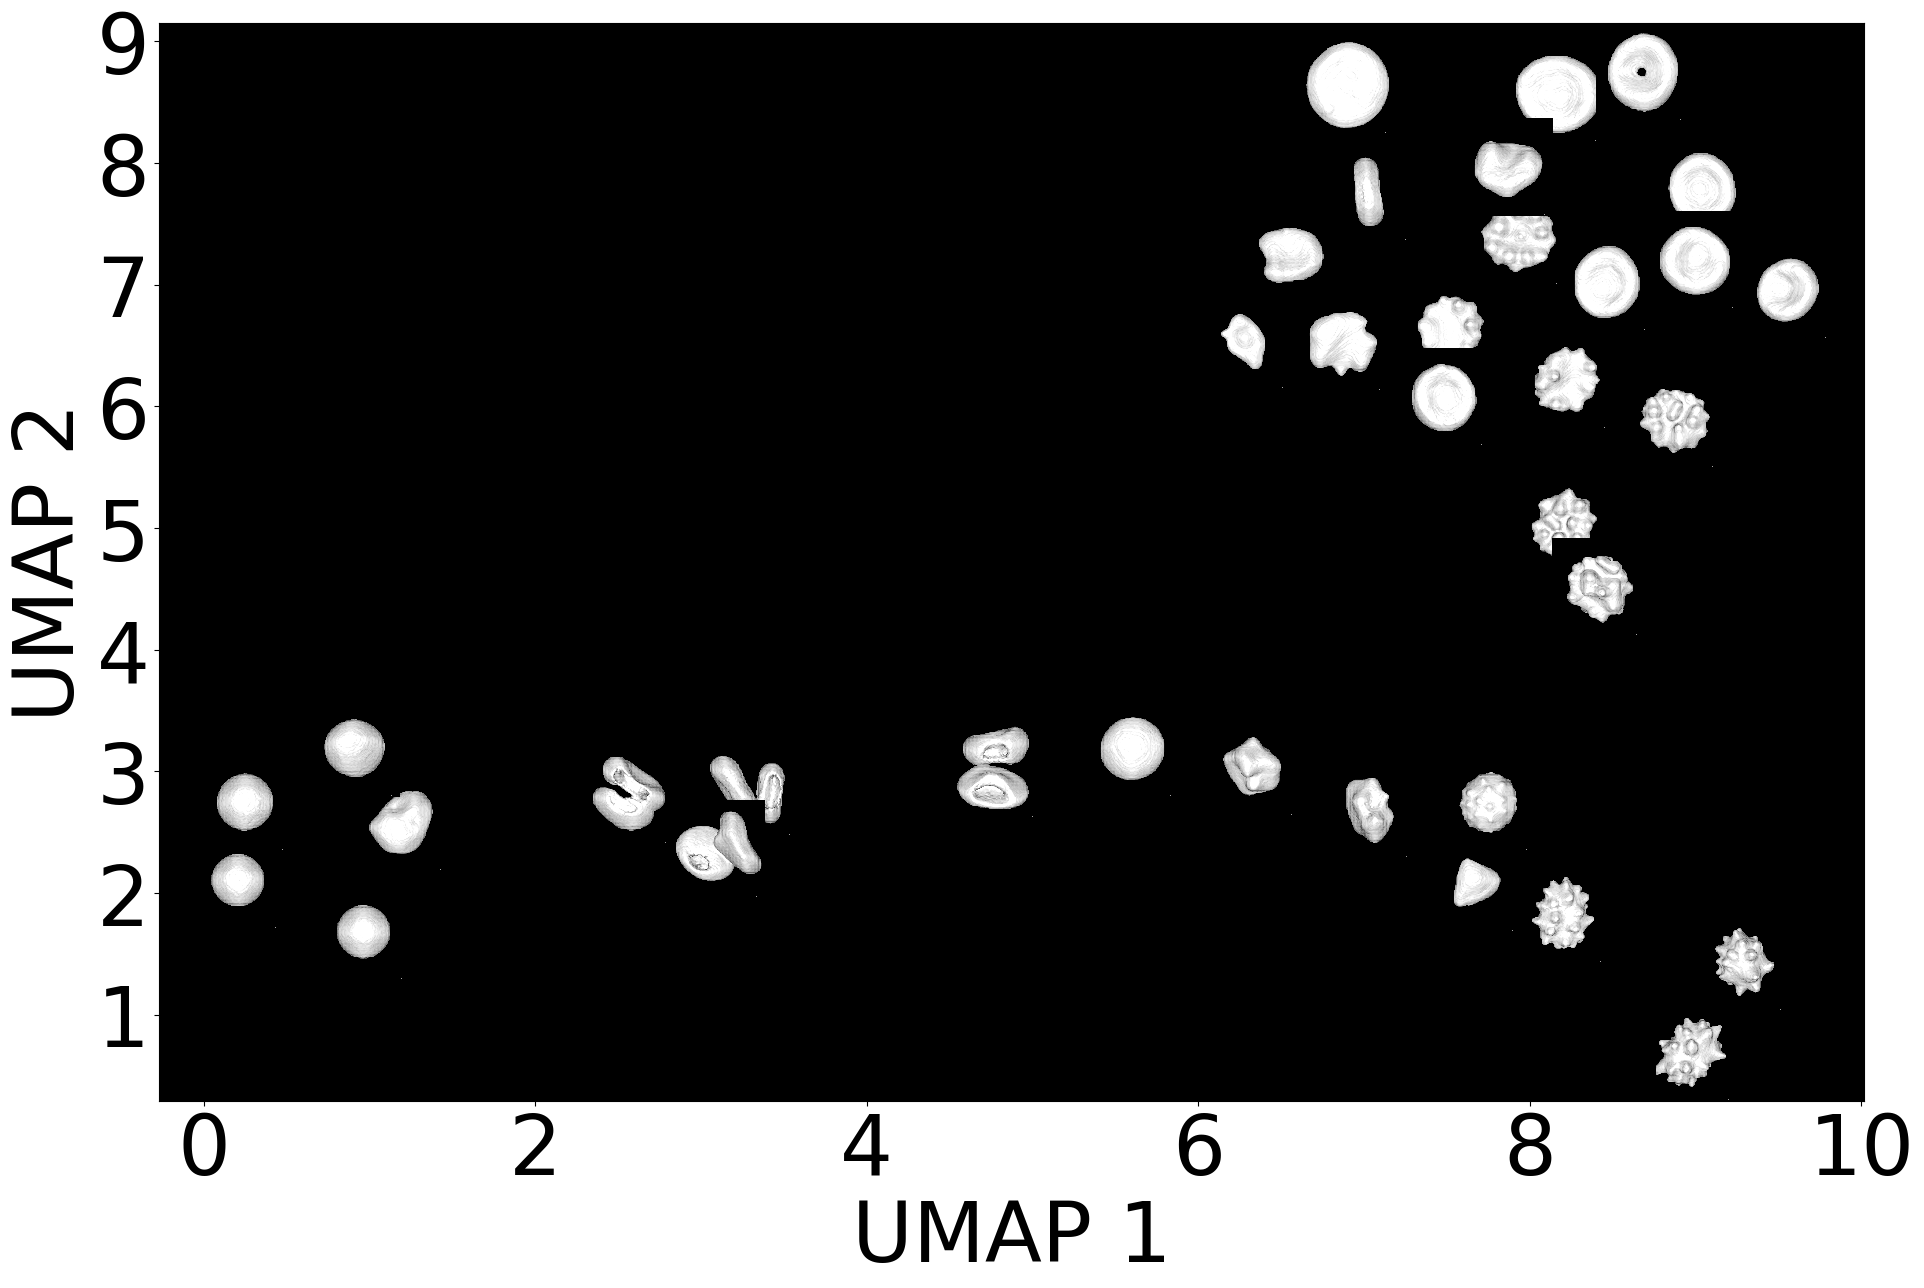

In [25]:
samples = extracted_df.sample(n=100)
new_x = []
new_x.append(-10)
new_y = []
new_y.append(-10)
new_serial = []
new_serial.append(-10)
new_plate = []
new_plate.append(-10)

for i in range(len(samples["UMAP1"])):
    curr_x = samples["UMAP1"].iloc[i]
    curr_y = samples["UMAP2"].iloc[i]
    for j in range(len(new_x)):
        if (abs(curr_x - new_x[j]) < 0.5) & (abs(curr_y - new_y[j]) < 0.5):
            add = False

            break
        else:
            add = True

    if add:
        new_x.append(curr_x)
        new_y.append(curr_y)
        new_serial.append(samples["FileName"].iloc[i])
#         new_plate.append(samples["PlateNumber"].iloc[i])

d = {
    "Umap1": new_x[1:],
    "Umap2": new_y[1:],
    "FileName": new_serial[1:],
    #     "PlateNumber": new_plate[1:],
}
df = pd.DataFrame(d)

plt.style.use(style="default")
plt.rcParams["figure.figsize"] = (22, 14)
plt.rcParams["axes.facecolor"] = "black"

path = "/home/mvries/Documents/Datasets/ShapeAE_datasets/RedBloodCell/"
all_images = plot_feature_landscape(path, df)

In [ ]:
extracted_df